In [1]:
import os
import string
import re
import pandas as pd
import pickle
import sklearn.metrics as metrics #courbe roc
import matplotlib.pyplot as plt #courbe roc
import numpy as np
import random
from random import sample

#os.chdir('C:/Users/torna/Documents/StatApp/StatApp')
os.chdir('C:/Users/Kim Antunez/Documents/Projets_autres/StatApp')
#os.chdir('/Users/alainquartierlatente/Desktop/Ensae/StatApp')
#os.chdir('/home/aqlt/Documents/Ensae/StatApp')

# Différentes fonctions utiles

In [2]:
# Faire un tirage aléatoire : soit 1 soit -1
def choix():
    return sample((1,-1),1)

# Faire autant de tirage aléatoire que la taille de corpus_train et 
#faire la moyenne
def choix_aleatoire(corpus_train):
    random.seed(1)
    sentiments_tweets = [[tweet, score, sample((1,-1),1)[0]] for (score, tweet) in corpus_train]
    resultat = [[tweet, 1 if val == score else 0] for (tweet, score, val) in sentiments_tweets]
    return(sum(res for (tweet,res) in resultat)/len(resultat))

In [3]:
def sentiment_plus(mot, matrice_sentiments):
    plus, moins = matrice_sentiments[mot]
    matrice_sentiments[mot] = (plus+1,moins)
    
def sentiment_moins(mot, matrice_sentiments):
    plus, moins = matrice_sentiments[mot]
    matrice_sentiments[mot] = (plus,moins+1)

# les sentiments des mots appartient à -1 1. 
def mat_sentiments(corpus, vocabulaire):   
    #Initialisation
    matrice_sent = {mot:(0,0) for mot in vocabulaire}
    for (score, tweet) in corpus:
        for mot in tweet.split():
            if score == 1:
                sentiment_plus(mot, matrice_sent)
            else:
                sentiment_moins(mot,matrice_sent)
    matrice_sentiments_val = {mot:(matrice_sent[mot][0]-matrice_sent[mot][1])/((matrice_sent[mot][0]+matrice_sent[mot][1]))
                          for mot in vocabulaire}
    return matrice_sentiments_val

Deux manières de calculer le sentiment : 
- Tu regardes le % de tweets positifs dans lesquels il intervient => tu as un sentiment entre 0 et 1
- **approche retenue ici** Tu regardes (Nb tweets positifs - Nb tweets négatifs)/Nb tot de tweet => tu as un sentiment entre -1 et 1 

In [4]:
# Le score de sentiment de la phrase est la moyenne des sentiments des mots 
def sentiments_phrase(phrase,matrice_sentiments):
    somme = 0
    n = 0
    for mot in phrase.split():
        if mot in matrice_sentiments.keys():
            somme += matrice_sentiments[mot]
        n += 1
    if(n!=0):
        return(somme/n)
    else:
        return 0

In [62]:
# Proportion de tweets qui sont positifs dans le corpus
def proportion_positifs(corpus, matrice_sentiments,seuil=0):
    resultat = [1 if score==1 else 0 for (score, tweet) in corpus]
    #print(len(resultat))
    compteur = 0
    n = 0
    for res in resultat:
        n += 1
        if res == 1:
            compteur+=1
    return(compteur/n)

In [6]:
def accuracy(sentiments_tweets, seuil=0):
    resultat = [[tweet, 1 if ((val >= seuil and score == 1) or (val < seuil and score == -1)) else 0]
            for (tweet, score, val) in sentiments_tweets]
    return sum(res for (tweet,res) in resultat)/len(resultat)

In [7]:
def accuracy_multiseuil(corpus, matrice_sentiments,seuil=0):
    #sentiments tweets continent : le tweet, son vrai score et le score de sentiment de la phrase 
    # qui appartient à -1 1. 
    sentiments_tweets = [[tweet, score, sentiments_phrase(tweet, matrice_sentiments)] for (score, tweet) in corpus]
    print("accuracy au seuil ", seuil, " : ", accuracy(sentiments_tweets, seuil))
    res_final = {seuils/100:accuracy(sentiments_tweets,seuils/100) for seuils in range(-100,100)}
    return(res_final)

In [8]:
def courbe_roc(corpus,methode,seuil=0,matrice_sentiments=None):
    if methode==1:
        sentiments_tweets = [[tweet, score, choix()[0]] for (score, tweet) in corpus]
    if methode==2:
        sentiments_tweets = [[tweet, score, sentiments_phrase(tweet, matrice_sentiments)] for (score, tweet) in corpus]
        sentiments_tweets = [[tweet, score, 1 if (val > seuil) else -1]
                for (tweet, score, val) in sentiments_tweets]
    preds = [res for (tweet, score, res) in sentiments_tweets] 
    Y_test = [score for (tweet, score, res) in sentiments_tweets] 
    fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    #plt.title('Courbe ROC - Régression logistique - Test')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('Taux de vrais positifs')
    plt.xlabel('Taux de faux positifs')
    plt.show()

# Modèle 1 aléatoire : on prédit 1 ou -1 de manière random

## Application sur base git 

In [63]:
with open("data/sentimental_analysis/corpus_test.file", "rb") as f:
    corpus_test = pickle.load(f)
with open("data/sentimental_analysis/corpus_train.file", "rb") as f:
    corpus_train = pickle.load(f)

In [10]:
print(choix_aleatoire(corpus_train))

0.50154


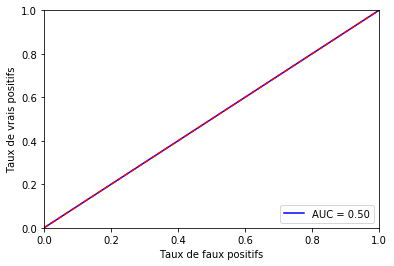

In [11]:
courbe_roc(corpus_train,methode=1,seuil=0,matrice_sentiments=None)

## Application sur base sncf

In [12]:
with open("data/sentimental_analysis/corpus_test_sncf.file", "rb") as f:
    corpus_test = pickle.load(f)
with open("data/sentimental_analysis/corpus_train_sncf.file", "rb") as f:
    corpus_train = pickle.load(f)

In [13]:
print(choix_aleatoire(corpus_train))

0.4969382654336416


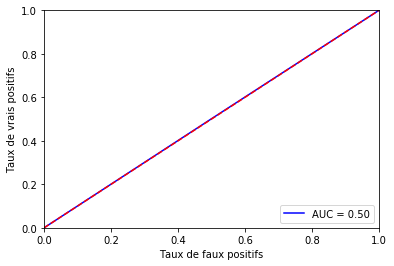

In [14]:
courbe_roc(corpus_train,methode=1,seuil=0,matrice_sentiments=None)

# Modèle 2 : prédiction sentiment de la phrase en fonction du sentiment moyen des mots

## Application sur base git 

In [64]:
with open("data/sentimental_analysis/corpus_test.file", "rb") as f:
    corpus_test = pickle.load(f)
with open("data/sentimental_analysis/corpus_train.file", "rb") as f:
    corpus_train = pickle.load(f)

In [65]:
print(len(corpus_test))
print(len(corpus_train))
print(len(corpus_test) + len(corpus_train))

3982
50000
53982


In [66]:
print("proportion positifs du train",
      proportion_positifs(corpus_train, matrice_sentiments_train,seuil=0))
print("proportion positifs du test",
      proportion_positifs(corpus_test, matrice_sentiments_train,seuil=0))

proportion positifs du train 0.5
proportion positifs du test 0.5017579105976896


In [17]:
phrases_train = [tweet.split() for (score, tweet) in corpus_train]
mots_train = [item for sublist in phrases_train for item in sublist]
vocabulaire_train = list(dict.fromkeys(mots_train))
print("Nombre de mots du train :", len(mots_train))
print("Taille du vocabulaire du train :", len(vocabulaire_train))

matrice_sentiments_train = mat_sentiments(corpus_train, vocabulaire_train)

print(matrice_sentiments_train["gentil"])
print(matrice_sentiments_train["méchant"])

Nombre de mots du train : 674732
Taille du vocabulaire du train : 39650
0.3333333333333333
-0.3448275862068966


In [24]:
# Enregistrement de la matrice_sentiment
#with open("data/sentimental_analysis/matrice_sentiment_baseline_git.file", "wb") as f:
#        pickle.dump(matrice_sentiments_train, f, pickle.HIGHEST_PROTOCOL)

Evaluation sur le train

In [18]:
accuracies_train = accuracy_multiseuil(corpus_train, matrice_sentiments_train,seuil=0)

accuracy au seuil  0  :  0.84454


Evaluation sur le test

In [19]:
# Attention pour évaluer le test, on prend la matrice de sentiment du train !
accuracies_test = accuracy_multiseuil(corpus_test, matrice_sentiments_train,seuil=0)

accuracy au seuil  0  :  0.7001506780512305


Distributions test VS train

In [20]:
import matplotlib.pyplot as plt
import numpy as np

In [21]:
keys_train = np.fromiter(accuracies_train.keys(), dtype=float)
vals_train = np.fromiter(accuracies_train.values(), dtype=float)

keys_test = np.fromiter(accuracies_test.keys(), dtype=float)
vals_test = np.fromiter(accuracies_test.values(), dtype=float)

Text(0, 0.5, 'Accuracy')

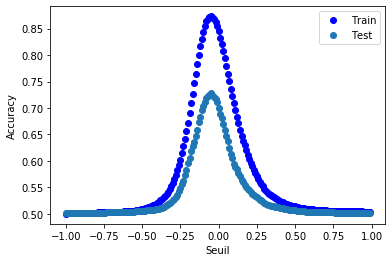

In [22]:
plt.plot(keys_train,vals_train,"bo")
plt.plot(keys_test,vals_test,'o')
plt.legend(["Train","Test"])
plt.xlabel('Seuil')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Accuracy')

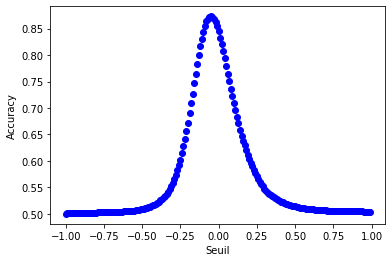

In [23]:
plt.plot(keys_train,vals_train,"bo")
plt.xlabel('Seuil')
plt.ylabel('Accuracy')

In [24]:
print("test :", [(key) for key in accuracies_test.keys()
                 if accuracies_test[key] == max(vals_test)])
print("train : ", [(key) for key in accuracies_train.keys()
                   if accuracies_train[key] == max(vals_train)])
seuil = -0.05

test : [-0.05]
train :  [-0.05]


In [25]:
print(accuracies_train[seuil])
print(accuracies_test[seuil])

0.87328
0.7290306378704169


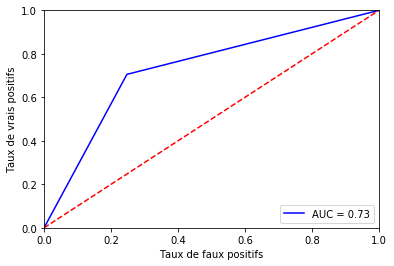

In [26]:
courbe_roc(corpus_test,methode=2,seuil=seuil,matrice_sentiments=matrice_sentiments_train)

## Application sur base sncf

In [67]:
with open("data/sentimental_analysis/corpus_test_sncf.file", "rb") as f:
    corpus_test = pickle.load(f)
with open("data/sentimental_analysis/corpus_train_sncf.file", "rb") as f:
    corpus_train = pickle.load(f)

In [68]:
print(len(corpus_test))
print(len(corpus_train))
print(len(corpus_test) + len(corpus_train))

6858
16004
22862


In [71]:
print("proportion positifs du train",
      proportion_positifs(corpus_train, matrice_sentiments_train,seuil=0))
print("proportion positifs du test",
      proportion_positifs(corpus_test, matrice_sentiments_train,seuil=0))

proportion positifs du train 0.4263934016495876
proportion positifs du test 0.426363371245261


In [70]:
phrases_train = [tweet.split() for (score, tweet) in corpus_train]
mots_train = [item for sublist in phrases_train for item in sublist]
vocabulaire_train = list(dict.fromkeys(mots_train))
print("Nombre de mots du train :", len(mots_train))
print("Taille du vocabulaire du train :", len(vocabulaire_train))

matrice_sentiments_train = mat_sentiments(corpus_train, vocabulaire_train)

print(matrice_sentiments_train["gentil"])
print(matrice_sentiments_train["méchant"])


Nombre de mots du train : 342106
Taille du vocabulaire du train : 26319
0.8235294117647058
0.3333333333333333


In [39]:
# Enregistrement de la matrice_sentiment
#with open("data/sentimental_analysis/matrice_sentiment_baseline_sncf.file", "wb") as f:
#        pickle.dump(matrice_sentiments_train, f, pickle.HIGHEST_PROTOCOL)

Evaluation sur le train

In [30]:
accuracies_train = accuracy_multiseuil(corpus_train, matrice_sentiments_train,seuil=0)

accuracy au seuil  0  :  0.744063984003999


Evaluation sur le test

In [31]:
# Attention pour évaluer le test, on prend la matrice de sentiment du train !
accuracies_test = accuracy_multiseuil(corpus_test, matrice_sentiments_train,seuil=0)

accuracy au seuil  0  :  0.705161854768154


Distributions test VS train

In [32]:
keys_train = np.fromiter(accuracies_train.keys(), dtype=float)
vals_train = np.fromiter(accuracies_train.values(), dtype=float)

keys_test = np.fromiter(accuracies_test.keys(), dtype=float)
vals_test = np.fromiter(accuracies_test.values(), dtype=float)

Text(0, 0.5, 'Accuracy')

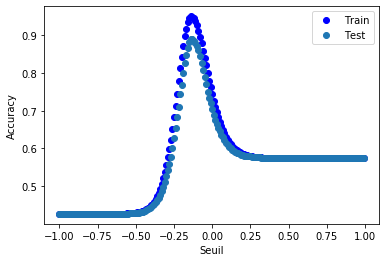

In [33]:
plt.plot(keys_train,vals_train,"bo")
plt.plot(keys_test,vals_test,'o')
plt.legend(["Train","Test"])
plt.xlabel('Seuil')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Accuracy (base de test)')

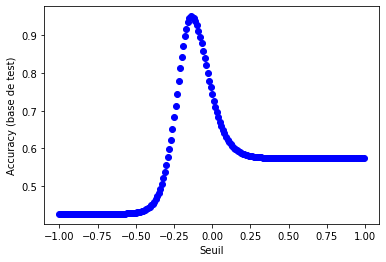

In [72]:
plt.plot(keys_train,vals_train,"bo")
plt.xlabel('Seuil')
plt.ylabel('Accuracy (base de test)')

In [35]:
print("test :", [(key) for key in accuracies_test.keys()
                 if accuracies_test[key] == max(vals_test)])
print("train : ", [(key) for key in accuracies_train.keys()
                   if accuracies_train[key] == max(vals_train)])
seuil = -0.14

test : [-0.14]
train :  [-0.14]


In [39]:
print(accuracies_train[seuil])
print(accuracies_train[0])
print(accuracies_test[seuil])
print(accuracies_test[0])

0.9502624343914021
0.744063984003999
0.8907844852726743
0.705161854768154


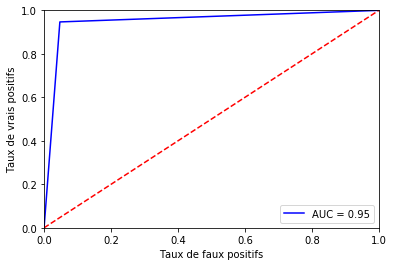

In [37]:
courbe_roc(corpus_train,methode=2,seuil=seuil,matrice_sentiments=matrice_sentiments_train)

### Traitements supplémentaires 

In [303]:
matrice_sentiments_train["pas"]

-0.25299029564432407

### Mots de la base test inconnus dans la base train - SNCF

In [45]:
with open("data/sentimental_analysis/corpus_test_sncf.file", "rb") as f:
    corpus_test = pickle.load(f)
with open("data/sentimental_analysis/corpus_train_sncf.file", "rb") as f:
    corpus_train = pickle.load(f)
with open("data/sentimental_analysis/corpus_test.file", "rb") as f:
    corpus_test_git = pickle.load(f)

In [46]:
phrases_train = [tweet.split() for (score, tweet) in corpus_train]
mots_train = [item for sublist in phrases_train for item in sublist]
vocabulaire_train = list(dict.fromkeys(mots_train))
phrases_test = [tweet.split() for (score, tweet) in corpus_test_git]
mots_test = [item for sublist in phrases_test for item in sublist]
vocabulaire_test = list(dict.fromkeys(mots_test))

In [47]:
# Apparition de chaque mot
app_test = {mot:0 for mot in vocabulaire_test}
for phrase in phrases_test:
    for mot in phrase:
        app_test[mot] += 1

In [ ]:
# après-coup : je crois qu'il y a un package qui le fait de manière opti...
# from nltk import word_tokenize
# fdist = nltk.FreqDist(mots_test)

In [48]:
# On compte :
# - le nombre de mots du voc en commun (compt)
# - le nombre de mots du corpus en commun (compt_mot)
compt = 0
compt_mot = 0
for mot in vocabulaire_test:
    for word in vocabulaire_train:
        # Ce qu'on trouve
        if mot == word:
            compt = compt +1
            compt_mot = compt_mot + app_test[mot]
print(compt)
print(compt_mot)

4103
46920


In [49]:
# Part des mots du voc non en commun
print(100*(len(vocabulaire_test) - compt)/len(vocabulaire_test))

52.039742840444184


In [50]:
# Part des mots du corpus non en commun
print(100*(len(mots_test) - compt_mot)/len(mots_test))

12.73133079140705


### Baseline SNCF sur corpus GIT

In [29]:
res_final_test = accuracy_multiseuil(corpus_test_git, matrice_sentiments_train)

proportion_positifs : 0.559266700150678
